In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import copy
import matplotlib.pyplot as plt
import glob
from pathlib import Path
import os
import plotly.express as px
from matplotlib import cm
import matplotlib as mpl
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import partial_dependence
import matplotlib as mpl
from matplotlib import cm
import cartopy.crs as ccrs
import cartopy
import random
import sklearn
import xarray as xr
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SequentialFeatureSelector
from scipy.stats import gaussian_kde
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant
from sklearn import tree
from sklearn.model_selection import cross_validate
import geopandas as gpd
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from pathos.threading import ThreadPool as Pool
from sklearn import datasets, linear_model
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


In [2]:
work_dir=Path("/mnt/u/LSM root zone/global_sr")
out_dir=Path("/mnt/u/LSM root zone/global_sr/output")
fig_dir=Path('/mnt/c/Users/fransjevanoors/surfdrive - Fransje van Oorschot@surfdrive.surf.nl/Fransje/global_SR/global_sr_paper/figures')

In [3]:
def cmap_map(function, cmap):
    """ Applies function (which should operate on vectors of shape 3: [r, g, b]), on colormap cmap.
    This routine will cmap_tempeak any discontinuous points in a colormap.
    """
    cdict = cmap._segmentdata
    step_dict = {}
    # Firt get the list of points where the segments start or end
    for key in ('red', 'green', 'blue'):
        step_dict[key] = list(map(lambda x: x[0], cdict[key]))
    step_list = sum(step_dict.values(), [])
    step_list = np.array(list(set(step_list)))
    # Then compute the LUT, and apply the function to the LUT
    reduced_cmap = lambda step : np.array(cmap(step)[0:3])
    old_LUT = np.array(list(map(reduced_cmap, step_list)))
    new_LUT = np.array(list(map(function, old_LUT)))
    # Now try to make a minimal segment definition of the new LUT
    cdict = {}
    for i, key in enumerate(['red','green','blue']):
        this_cdict = {}
        for j, step in enumerate(step_list):
            if step in step_dict[key]:
                this_cdict[step] = new_LUT[j, i]
            elif new_LUT[j,i] != old_LUT[j, i]:
                this_cdict[step] = new_LUT[j, i]
        colorvector = list(map(lambda x: x + (x[1], ), this_cdict.items()))
        colorvector.sort()
        cdict[key] = colorvector

    return matplotlib.colors.LinearSegmentedColormap('colormap',cdict,1024)

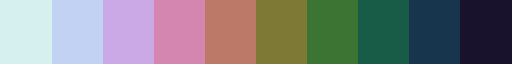

In [4]:
cmap = cm.get_cmap('cubehelix_r', 12)
color_list = [matplotlib.colors.rgb2hex(cmap(i)[:3]) for i in range(cmap.N)]
cmap_sr = ListedColormap(color_list[1:-1])
cmap_sr.set_over(color_list[-1])
cmap_sr.set_under(color_list[0])
cmap_sr.set_bad('lightgrey')
cmap_sr

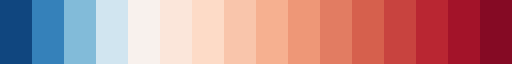

In [5]:
#cmap temperature
cmap = cm.get_cmap('RdBu_r', 26)
cl = [matplotlib.colors.rgb2hex(cmap(i)[:3]) for i in range(cmap.N)]
blues = [cl[1],cl[4],cl[7],cl[10]]
reds = cl[13:25]
cmap_temp = ListedColormap(np.concatenate([blues,reds]))
cmap_temp.set_over(cl[-1])
cmap_temp.set_under(cl[0])
cmap_temp.set_bad('lightgrey')
cmap_temp

## gridded variables

In [6]:
data_sources = 'gswp-p_gleam-ep_gswp-t'
df = pd.read_csv(f'{work_dir}/output/catchment_characteristics/master_characteristics_{data_sources}_v2.csv',index_col=0)
df = df.drop(columns=['ppd_l'])
df = df[df.p_mean-df.q_mean < df.ep_mean]
df = df[['p_mean','ep_mean', 't_mean','tdiff_mean','idu_mean', 'si_ep','si_p', 'asi','dtb','ia','slp_mean','el_mean','tc','ntc','nonveg','pclay','psand','lai_mean','lai_rsd','sc_mean','sc_rsd','sr_20','lat','lon']]
df = df.dropna()

In [7]:
p = xr.open_dataset(f'{work_dir}/output/gridded_sr/p_mean_gswp3_land.nc')
t = xr.open_dataset(f'{work_dir}/output/gridded_sr/t_mean_gswp3_land.nc')
idu = xr.open_dataset(f'{work_dir}/output/gridded_sr/idu_mean_land.nc')
asi = xr.open_dataset(f'{work_dir}/output/gridded_sr/asi_land.nc')
p_days = xr.open_dataset(f'{work_dir}/output/gridded_sr/p_days_land.nc')
lai = xr.open_dataset(f'{work_dir}/output/gridded_sr/lai_mean_land.nc')

In [8]:
# mask out points outside catchment ranges
p5 = df.p_mean.quantile(0.05)
p95 = df.p_mean.quantile(0.95)
pl= xr.where(((p.pr>=p5)&(p.pr<=p95)), p.pr, np.nan)

t5 = df.t_mean.quantile(0.05)
t95 = df.t_mean.quantile(0.95)
tl= xr.where(((t.tas>=t5)&(t.tas<=t95)), t.tas, np.nan)

idu5 = df.idu_mean.quantile(0.05)
idu95 = df.idu_mean.quantile(0.95)
idul= xr.where(((idu.idu_mean>=idu5)&(idu.idu_mean<=idu95)), idu.idu_mean, np.nan)

asi5 = df.asi.quantile(0.05)
asi95 = df.asi.quantile(0.95)
asil= xr.where(((asi.asi>=asi5)&(asi.asi<=asi95)), asi.asi, np.nan)

# make one mask
pl = xr.where(((pl>=0)&(idul>=0)&(asil>=0)&(tl>=-50)),pl,np.nan)
tl = xr.where(((pl>=0)&(idul>=0)&(asil>=0)&(tl>=-50)),tl,np.nan)
asil = xr.where(((pl>=0)&(idul>=0)&(asil>=0)&(tl>=-50)),asil,np.nan)
idul = xr.where(((pl>=0)&(idul>=0)&(asil>=0)&(tl>=-50)),idul,np.nan)

In [9]:
# mask out points outside catchment ranges
p5 = df.p_mean.quantile(0.01)
p95 = df.p_mean.quantile(0.99)
pl= xr.where(((p.pr>=p5)&(p.pr<=p95)), p.pr, np.nan)

t5 = df.t_mean.quantile(0.01)
t95 = df.t_mean.quantile(0.99)
tl= xr.where(((t.tas>=t5)&(t.tas<=t95)), t.tas, np.nan)

idu5 = df.idu_mean.quantile(0.01)
idu95 = df.idu_mean.quantile(0.99)
idul= xr.where(((idu.idu_mean>=idu5)&(idu.idu_mean<=idu95)), idu.idu_mean, np.nan)

asi5 = df.asi.quantile(0.01)
asi95 = df.asi.quantile(0.99)
asil= xr.where(((asi.asi>=asi5)&(asi.asi<=asi95)), asi.asi, np.nan)

# make one mask
pl = xr.where(((pl>=0)&(idul>=0)&(asil>=0)&(tl>=-50)),pl,np.nan)
tl = xr.where(((pl>=0)&(idul>=0)&(asil>=0)&(tl>=-50)),tl,np.nan)
asil = xr.where(((pl>=0)&(idul>=0)&(asil>=0)&(tl>=-50)),asil,np.nan)
idul = xr.where(((pl>=0)&(idul>=0)&(asil>=0)&(tl>=-50)),idul,np.nan)

In [10]:
# mask out points outside catchment ranges
pmax = df.p_mean.max()
pmin = df.p_mean.min()
pl= xr.where(((p.pr>=pmin)&(p.pr<=pmax)), p.pr, np.nan)

tmax = df.t_mean.max()
tmin = df.t_mean.min()
tl= xr.where(((t.tas>=tmin)&(t.tas<=tmax)), t.tas, np.nan)

idumax = df.idu_mean.max()
idumin = df.idu_mean.min()
idul= xr.where(((idu.idu_mean>=idumin)&(idu.idu_mean<=idumax)), idu.idu_mean, np.nan)

asimax = df.asi.max()
asimin = df.asi.min()
asil= xr.where(((asi.asi>=asimin)&(asi.asi<=asimax)), asi.asi, np.nan)

# make one mask
pl = xr.where(((pl>=0)&(idul>=0)&(asil>=0)&(tl>=-50)),pl,np.nan)
tl = xr.where(((pl>=0)&(idul>=0)&(asil>=0)&(tl>=-50)),tl,np.nan)
asil = xr.where(((pl>=0)&(idul>=0)&(asil>=0)&(tl>=-50)),asil,np.nan)
idul = xr.where(((pl>=0)&(idul>=0)&(asil>=0)&(tl>=-50)),idul,np.nan)

/tmp/ipykernel_1722/1419862687.py:27: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("PuRd").copy()
  cmap.set_bad('lightgrey')
/tmp/ipykernel_1722/1419862687.py:45: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("YlGnBu").copy()
  cmap.set_bad('lightgrey')
/tmp/ipykernel_1722/1419862687.py:64: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove

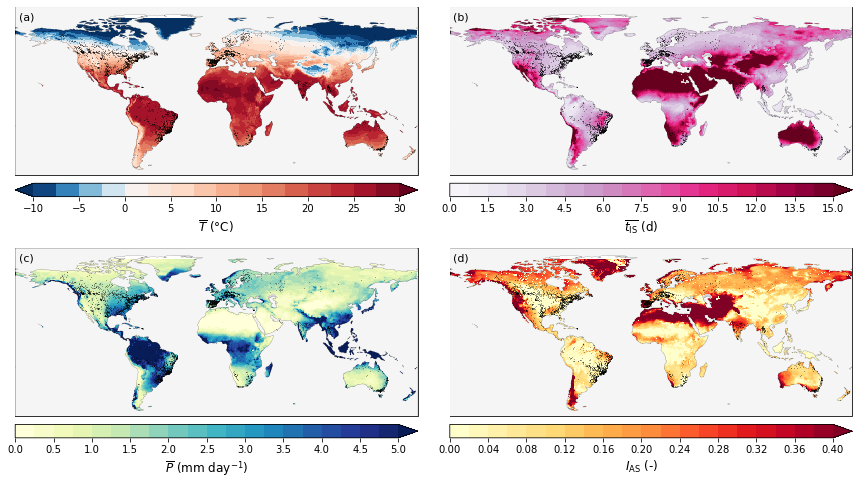

In [11]:
fig2 = plt.figure(figsize=(15,15))
ax = fig2.add_subplot(221,projection=ccrs.PlateCarree())
plt.subplots_adjust(wspace=0.08,hspace=-0.58)

# t mean
lvls = np.linspace(-10,30,17)
lvls2 = np.linspace(-10,30,17)
cmap = cmap_temp
ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
# ax.plot(df.lon,df.lat,marker='o',markeredgecolor='k',markerfacecolor=None,markeredgewidth=0.1,markersize=0.5,linestyle='None',zorder=101)
ax.plot(df.lon,df.lat,marker='x',markeredgecolor=(0,0,0,0.6),markerfacecolor=None,markersize=0.2,linestyle='None',zorder=101)
a = (t.tas[0,:,:]).plot(ax=ax, cmap=cmap,levels=lvls,add_colorbar=False)
cbar = plt.colorbar(a, orientation='horizontal',spacing='proportional',extend='both', pad=0.015,aspect=30)
cbar.set_label('$\overline{T}$ ($\degree$C)',size=12)
# cbar.set_ticklabels(['-100','-75','-50','-25','0','25','50','75','100'],size=7)
ax.set_title('')
ax.text(-177,78,'(a)',size=11,zorder=101)

# idu mean
lvls = np.linspace(0,15,21)
lvls2 = np.linspace(0,15,11)
cmap = cm.get_cmap('PuRd')
cmap.set_bad('lightgrey')
ax = fig2.add_subplot(222,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
ax.plot(df.lon,df.lat,marker='x',markeredgecolor=(0,0,0,0.6),markerfacecolor=None,markersize=0.2,linestyle='None',zorder=101)
a = (idu.idu_mean[:,:]).plot(ax=ax, cmap=cmap,levels=lvls, add_colorbar=False)
cbar = plt.colorbar(a, orientation='horizontal',spacing='proportional',extend='max', pad=0.015,aspect=30,ticks=lvls2)
cbar.set_label('$\overline{t_\mathrm{IS}}$ (d)',size=12)
# cbar.set_ticklabels(['-100','-75','-50','-25','0','25','50','75','100'],size=7)
ax.text(-177,78,'(b)',size=11,zorder=101)

# p mean
lvls = np.linspace(0,5,21)
lvls2 = np.linspace(0,5,11)
cmap = cm.get_cmap('YlGnBu')
cmap.set_bad('lightgrey')
ax = fig2.add_subplot(223,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
ax.plot(df.lon,df.lat,marker='x',markeredgecolor=(0,0,0,0.6),markerfacecolor=None,markersize=0.2,linestyle='None',zorder=101)
a = (p.pr[0,:,:]).plot(ax=ax, cmap=cmap,levels=lvls, add_colorbar=False)
cbar = plt.colorbar(a, orientation='horizontal', spacing='proportional',extend='max', pad=0.015,aspect=30,ticks=lvls2)
ax.text(-177,78,'(c)',size=11,zorder=101)
ax.set_title('')
cbar.set_label('$\overline{P}$ ($\mathrm{mm}$ $\mathrm{day}^{-1}$)',size=12)
# cbar.set_ticklabels(['-100','-75','-50','-25','0','25','50','75','100'],size=7)

# asi
lvls = np.linspace(0,0.4,21)
lvls2 = np.linspace(0,0.4,11)
cmap = cm.get_cmap('YlOrRd')
cmap.set_bad('lightgrey')
ax = fig2.add_subplot(224,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
ax.plot(df.lon,df.lat,marker='x',markeredgecolor=(0,0,0,0.6),markerfacecolor=None,markersize=0.2,linestyle='None',zorder=101)
a = (asi.asi[:,:]).plot(ax=ax, cmap=cmap,levels=lvls, add_colorbar=False)
cbar = plt.colorbar(a, orientation='horizontal',spacing='proportional',extend='max', pad=0.015,aspect=30,ticks=lvls2)
cbar.set_label('$I_\mathrm{AS}$ (-)',size=12)
# cbar.set_ticklabels(['-100','-75','-50','-25','0','25','50','75','100'],size=7)
ax.text(-177,78,'(d)',size=11,zorder=101)

fig2.savefig(f'{out_dir}/gridded_sr/figures/4_variables_maps.jpg',bbox_inches='tight',dpi=300)


/tmp/ipykernel_1722/424511769.py:30: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("PuRd").copy()
  cmap.set_bad('lightgrey')
/tmp/ipykernel_1722/424511769.py:49: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("YlGnBu").copy()
  cmap.set_bad('lightgrey')
/tmp/ipykernel_1722/424511769.py:68: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove th

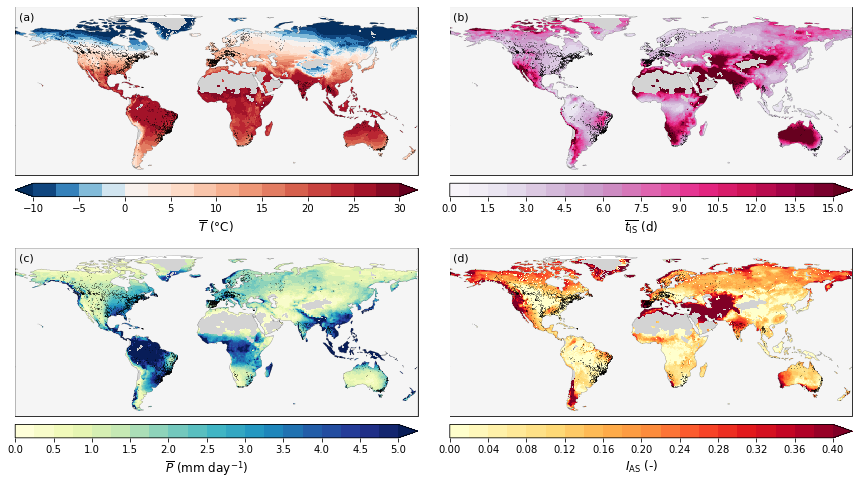

In [12]:
# mask out values outside range
fig2 = plt.figure(figsize=(15,15))
ax = fig2.add_subplot(221,projection=ccrs.PlateCarree())
plt.subplots_adjust(wspace=0.08,hspace=-0.58)

# t mean
lvls = np.linspace(-10,30,17)
lvls2 = np.linspace(-10,30,17)
cmap = cmap_temp
tl[0,0,0]=-15
tl[0,0,1]=35
ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
# ax.plot(df.lon,df.lat,marker='o',markeredgecolor='k',markerfacecolor=None,markeredgewidth=0.1,markersize=0.5,linestyle='None',zorder=101)
ax.plot(df.lon,df.lat,marker='x',markeredgecolor=(0,0,0,0.6),markerfacecolor=None,markersize=0.2,linestyle='None',zorder=101)
a = (tl[0,:,:]).plot(ax=ax, cmap=cmap,levels=lvls,add_colorbar=False)
cbar = plt.colorbar(a, orientation='horizontal',spacing='proportional',extend='both', pad=0.015,aspect=30)
cbar.set_label('$\overline{T}$ ($\degree$C)',size=12)
# cbar.set_ticklabels(['-100','-75','-50','-25','0','25','50','75','100'],size=7)
ax.set_title('')
ax.text(-177,78,'(a)',size=11,zorder=101)

# idu mean
lvls = np.linspace(0,15,21)
lvls2 = np.linspace(0,15,11)
cmap = cm.get_cmap('PuRd')
cmap.set_bad('lightgrey')
ax = fig2.add_subplot(222,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
ax.plot(df.lon,df.lat,marker='x',markeredgecolor=(0,0,0,0.6),markerfacecolor=None,markersize=0.2,linestyle='None',zorder=101)
a = (idul[:,:]).plot(ax=ax, cmap=cmap,levels=lvls, add_colorbar=False)
cbar = plt.colorbar(a, orientation='horizontal',spacing='proportional',extend='max', pad=0.015,aspect=30,ticks=lvls2)
cbar.set_label('$\overline{t_\mathrm{IS}}$ (d)',size=12)
# cbar.set_ticklabels(['-100','-75','-50','-25','0','25','50','75','100'],size=7)
ax.text(-177,78,'(b)',size=11,zorder=101)
ax.set_title('')

# p mean
lvls = np.linspace(0,5,21)
lvls2 = np.linspace(0,5,11)
cmap = cm.get_cmap('YlGnBu')
cmap.set_bad('lightgrey')
ax = fig2.add_subplot(223,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
ax.plot(df.lon,df.lat,marker='x',markeredgecolor=(0,0,0,0.6),markerfacecolor=None,markersize=0.2,linestyle='None',zorder=101)
a = (pl[0,:,:]).plot(ax=ax, cmap=cmap,levels=lvls, add_colorbar=False)
cbar = plt.colorbar(a, orientation='horizontal', spacing='proportional',extend='max', pad=0.015,aspect=30,ticks=lvls2)
ax.text(-177,78,'(c)',size=11,zorder=101)
ax.set_title('')
cbar.set_label('$\overline{P}$ ($\mathrm{mm}$ $\mathrm{day}^{-1}$)',size=12)
# cbar.set_ticklabels(['-100','-75','-50','-25','0','25','50','75','100'],size=7)

# asi
lvls = np.linspace(0,0.4,21)
lvls2 = np.linspace(0,0.4,11)
cmap = cm.get_cmap('YlOrRd')
cmap.set_bad('lightgrey')
ax = fig2.add_subplot(224,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
ax.plot(df.lon,df.lat,marker='x',markeredgecolor=(0,0,0,0.6),markerfacecolor=None,markersize=0.2,linestyle='None',zorder=101)
a = (asil).plot(ax=ax, cmap=cmap,levels=lvls, add_colorbar=False)
cbar = plt.colorbar(a, orientation='horizontal',spacing='proportional',extend='max', pad=0.015,aspect=30,ticks=lvls2)
cbar.set_label('$I_\mathrm{AS}$ (-)',size=12)
# cbar.set_ticklabels(['-100','-75','-50','-25','0','25','50','75','100'],size=7)
ax.text(-177,78,'(d)',size=11,zorder=101)
ax.set_title('')
fig2.savefig(f'{out_dir}/gridded_sr/figures/4_variables_maps.jpg',bbox_inches='tight',dpi=300)


Text(0.5, 1.0, '')

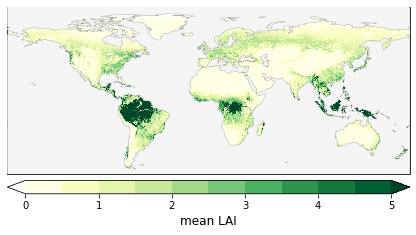

In [13]:
# lai
fig2 = plt.figure(figsize=(15,15))
ax = fig2.add_subplot(221,projection=ccrs.PlateCarree())
plt.subplots_adjust(wspace=0.08,hspace=-0.01)

# t mean
lvls = np.linspace(0,5,11)
lvls2 = np.linspace(0,5,11)
cmap = 'YlGn'
ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
# ax.plot(df.lon,df.lat,marker='o',markeredgecolor='k',markerfacecolor=None,markeredgewidth=0.1,markersize=0.5,linestyle='None',zorder=101)
# ax.plot(df.lon,df.lat,marker='x',markeredgecolor=(0,0,0,0.6),markerfacecolor=None,markersize=2.2,linestyle='None',zorder=101)
a = (lai.LAI[0,:,:]).plot(ax=ax, cmap=cmap,levels=lvls,add_colorbar=False)
cbar = plt.colorbar(a, orientation='horizontal',spacing='proportional',extend='both', pad=0.015,aspect=30)
cbar.set_label('mean LAI',size=12)
# cbar.set_ticklabels(['-100','-75','-50','-25','0','25','50','75','100'],size=7)
ax.set_title('')
# ax.text(-177,78,'(a)',size=11,zorder=101)


## Apply RF to gridded data

In [14]:
min_samples_leaf=1
max_depth=None
data_sources = 'gswp-p_gleam-ep_gswp-t'
# data_sources = 'gswp-p_hs-ep_gswp-t'

In [15]:
df = pd.read_csv(f'{work_dir}/output/catchment_characteristics/master_characteristics_{data_sources}_v2.csv',index_col=0)
df = df.drop(columns=['ppd_l'])
df = df[df.p_mean-df.q_mean < df.ep_mean]
df = df[['p_mean','ep_mean', 't_mean','tdiff_mean','idu_mean', 'si_ep','si_p', 'asi','dtb','ia','slp_mean','el_mean','tc','ntc','nonveg','pclay','psand','lai_mean','lai_rsd','sc_mean','sc_rsd','sr_20','lat','lon']]
df = df.dropna()
df['catch_id'] = df.index
features = ['idu_mean','t_mean','asi','p_mean']#,'lai_mean']

In [16]:
# features = ['p_mean','ep_mean', 't_mean','tdiff_mean','idu_mean', 'si_ep','si_p', 'asi','dtb','ia','slp_mean','el_mean','tc','ntc','nonveg','pclay','psand','lai_mean','lai_rsd','sc_mean','sc_rsd']
sr_rp = 'sr_20'
ll = ['lat','lon','catch_id']
f = features + ll
dfx = df[f].values
dfy = df[sr_rp].values

# here split dataset into 'temp' and 'test'
cv_outer = 5 # the number of outer cross validations
sdf = pd.DataFrame(index=range(cv_outer), columns=['n_estimators','max_depth','min_samples_leaf','max_features','train_mae','train_r2_adj','test_mae','test_r2_adj','n_train','n_test','fold'])
l = []
train_dfs=[]
test_dfs=[]

kf = KFold(n_splits=cv_outer,shuffle=True,random_state=0)
df = dfy.reshape(-1, 1).ravel()
i=0
cv_train_ix = []
cv_test_ix = []
ddl = []
for train_ix, test_ix in kf.split(dfx):
    cv_train_ix.append(train_ix)
    cv_test_ix.append(test_ix)
    X = dfx[train_ix]
    y = dfy[train_ix]
    X_test = dfx[test_ix]
    y_test = dfy[test_ix] 
    
    # save lat lon columns
    lat_train = X[:,-3]
    lon_train = X[:,-2]
    lat_test = X_test[:,-3]
    lon_test = X_test[:,-2]
    catch_id_train = X[:,-1]
    catch_id_test = X_test[:,-1]

    # remove lat lon catchid columns
    X = np.delete(X,-1,1)
    X = np.delete(X,-1,1)
    X = np.delete(X,-1,1)
    X_test = np.delete(X_test,-1,1)
    X_test = np.delete(X_test,-1,1)
    X_test = np.delete(X_test,-1,1)  
    
    # run rf model with full 'temp' set and test set using the best inner cross validation
    rf = RandomForestRegressor(criterion='absolute_error',random_state=42,max_depth=max_depth,min_samples_leaf=min_samples_leaf,oob_score=True)
    rf.fit(X,y)
    test_y_pred = rf.predict(X_test)
    train_y_pred = rf.predict(X)
    n_train,n_test = len(y),len(y_test)

    train_mae = np.round(mean_absolute_error(y, train_y_pred),2)
    # train_r2_adj =  np.round(r2_adj(y, train_y_pred,features),2)

    test_mae = np.round(mean_absolute_error(y_test, test_y_pred),2)
    # test_r2_adj = np.round(r2_adj(y_test, test_y_pred,features),2)
    
    perm_importance = permutation_importance(rf, X_test, y_test,scoring='neg_mean_absolute_error',random_state=42)
    # perm_importance = permutation_importance(rf, X_train, y_test,scoring='neg_mean_absolute_error',random_state=42)
    pi = perm_importance.importances_mean
    dd = pd.DataFrame(index=features,columns=['pi'])
    dd.pi = pi
    ddl.append(dd)
    
    df_train = pd.DataFrame(index=catch_id_train,columns=['lat','lon','Sr_m','Sr_p','Sr_p-Sr_m','(Sr_p-Sr_m)/Sr_m'])
    df_train['lat'] = lat_train
    df_train['lon'] = lon_train
    df_train['Sr_m'] = y
    df_train['Sr_p'] = train_y_pred
    df_train['Sr_p-Sr_m'] = train_y_pred - y
    df_train['(Sr_p-Sr_m)/Sr_m'] = (train_y_pred - y)/train_y_pred
    train_dfs.append(df_train)

    df_test = pd.DataFrame(index=catch_id_test,columns=['lat','lon','Sr_m','Sr_p','Sr_p-Sr_m','(Sr_p-Sr_m)/Sr_m'])
    df_test['lat'] = lat_test
    df_test['lon'] = lon_test
    df_test['Sr_m'] = y_test
    df_test['Sr_p'] = test_y_pred
    df_test['Sr_p-Sr_m'] = test_y_pred - y_test
    df_test['(Sr_p-Sr_m)/Sr_m'] = (test_y_pred - y_test)/test_y_pred
    test_dfs.append(df_test)

    i+=1

test_dfs = pd.concat(test_dfs)
train_dfs = pd.concat(train_dfs)


# sdf.to_csv(f'{work_dir}/cross_validation/output/sdf_kinner{cv_inner}_kouter{cv_outer}_var{len(features)}_v2.csv')

In [17]:
p = xr.open_dataset(f'{work_dir}/output/gridded_sr/p_mean_gswp3_land.nc')
t = xr.open_dataset(f'{work_dir}/output/gridded_sr/t_mean_gswp3_land.nc')
idu = xr.open_dataset(f'{work_dir}/output/gridded_sr/idu_mean_land.nc')
asi = xr.open_dataset(f'{work_dir}/output/gridded_sr/asi_land.nc')
# lai = xr.open_dataset(f'{work_dir}/output/gridded_sr/lai_mean_land.nc')

p_array = p.pr.to_numpy().flatten()
t_array = t.tas.to_numpy().flatten()
asi_array = asi.asi.to_numpy().flatten()
idu_array = idu.idu_mean.to_numpy().flatten()
# lai_array = lai.LAI.to_numpy().flatten()

lat_array = []
lon_array = []
for m in range(len(p.lat.values)):
    for n in range(len(p.lon.values)):
        lat_array.append(p.lat.values[m])
        lon_array.append(p.lon.values[n])

In [18]:
df = pd.read_csv(f'{work_dir}/output/catchment_characteristics/master_characteristics_{data_sources}_v2.csv',index_col=0)
df = df.drop(columns=['ppd_l'])
df = df[df.p_mean-df.q_mean < df.ep_mean]
df = df[['p_mean','ep_mean', 't_mean','tdiff_mean','idu_mean', 'si_ep','si_p', 'asi','dtb','ia','slp_mean','el_mean','tc','ntc','nonveg','pclay','psand','lai_mean','lai_rsd','sc_mean','sc_rsd','sr_20','lat','lon']]
df = df.dropna()
features = ['p_mean','t_mean', 'asi','idu_mean']#,'lai_mean']

# adf = pd.DataFrame(columns=df.columns)
# for i in range(50):
#     adf.loc[i]= df.loc['om_0000002'] # copy this catchment 50x to represent better dry catchments
# for i in range(50):
#     adf.loc[i+50]= df.loc['na_0000048']
# df = pd.concat([df,adf])
# # df = pd.concat([df,ldf])

dfs=[]

for i in range(5):
    sr_rp = 'sr_20'
    df['catch_id'] = df.index
    ll = ['lat','lon','catch_id']
    f = features + ll
    dfx = df[f].values
    dfy = df[sr_rp].values
    train_ix = cv_train_ix[i]
    test_ix = cv_test_ix[i]

    # X_train, X_test, y_train, y_test = train_test_split(dfx, dfy.reshape(-1, 1).ravel(), test_size=0.3, random_state=42)
    X_train = dfx[train_ix]
    y_train = dfy[train_ix]
    X_test = dfx[test_ix]
    y_test = dfy[test_ix]

    # save lat lon columns
    lat_train = X_train[:,-3]
    lon_train = X_train[:,-2]
    lat_test = X_test[:,-3]
    lon_test = X_test[:,-2]
    catch_id_train = X_train[:,-1]
    catch_id_test = X_test[:,-1]
    # remove lat lon columns
    X_train = np.delete(X_train,-1,1)
    X_train = np.delete(X_train,-1,1)
    X_train = np.delete(X_train,-1,1)
    X_test = np.delete(X_test,-1,1)
    X_test = np.delete(X_test,-1,1)
    X_test = np.delete(X_test,-1,1)

    rf = RandomForestRegressor(criterion='absolute_error',random_state=42,min_samples_leaf=min_samples_leaf,max_depth=max_depth)
    # rf = RandomForestRegressor(criterion='squared_error',random_state=42,min_samples_leaf=min_samples_leaf,max_depth=max_depth,oob_score=True)
    rf = rf.fit(X_train, y_train)
    train_y_pred = rf.predict(X_train)
    
    dfg = pd.DataFrame(index=np.arange(0,195840,1), columns=['lat','lon','p_mean','t_mean','asi','idu_mean'])#,'lai_mean'])
    dfg.loc[:,'lat'] = lat_array
    dfg.loc[:,'lon'] = lon_array
    dfg.loc[:,'p_mean'] = p_array
    dfg.loc[:,'t_mean'] = t_array
    dfg.loc[:,'asi'] = asi_array
    dfg.loc[:,'idu_mean'] = idu_array
    # dfg.loc[:,'lai_mean'] = lai_array
    dfg = dfg.dropna()
    
    dfx = dfg[features].values
    test_y_pred = rf.predict(dfx)
    dfg['sr_pred'] = test_y_pred
    dfs.append(dfg)

In [19]:
df0 = dfs[0]
df1 = dfs[1]
df2 = dfs[2]
df3 = dfs[3]
df4 = dfs[4]

In [20]:
dfp = pd.DataFrame(index=np.arange(0,195840,1), columns=['lat','lon','sr_p0','sr_p1','sr_p2','sr_p3','sr_p4'])
dfp.loc[:,'lat'] = lat_array
dfp.loc[:,'lon'] = lon_array
dfp['sr_p0'] = df0['sr_pred']
dfp['sr_p1'] = df1['sr_pred']
dfp['sr_p2'] = df2['sr_pred']
dfp['sr_p3'] = df3['sr_pred']
dfp['sr_p4'] = df4['sr_pred']
dfp['sr_p_mean'] = dfp[['sr_p0','sr_p1','sr_p2','sr_p3','sr_p4']].mean(axis=1)
dfp['sr_p_std'] = dfp[['sr_p0','sr_p1','sr_p2','sr_p3','sr_p4']].std(axis=1)
dfp['sr_p_sm'] = dfp['sr_p_std']/dfp['sr_p_mean']
dfp

,lat,lon,sr_p0,sr_p1,sr_p2,sr_p3,sr_p4,sr_p_mean,sr_p_std,sr_p_sm
0,80.0,-180.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,80.0,-179.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,80.0,-179.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,80.0,-178.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,80.0,-178.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
195835,-55.5,177.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
195836,-55.5,178.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
195837,-55.5,178.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
195838,-55.5,179.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [58]:
# dataframe to 2d xarray
# mean
srp = np.zeros([len(p.lat.values),len(p.lon.values)])
i=0
for n in range(len(p.lat.values)):
    for m in range(len(p.lon.values)):
        srp[n,m] = dfp['sr_p_mean'][i]
        i+=1
lon = p.lon.values
lat = p.lat.values
data_xr_mean = xr.DataArray(srp,
                       coords={'lat':lat,'lon':lon},
                       dims=['lat','lon'],
                       name='sr_p')

# std
srp = np.zeros([len(p.lat.values),len(p.lon.values)])
i=0
for n in range(len(p.lat.values)):
    for m in range(len(p.lon.values)):
        srp[n,m] = dfp['sr_p_std'][i]
        i+=1
lon = p.lon.values
lat = p.lat.values
data_xr_std = xr.DataArray(srp,
                       coords={'lat':lat,'lon':lon},
                       dims=['lat','lon'],
                       name='sr_p')

# std/mean
srp = np.zeros([len(p.lat.values),len(p.lon.values)])
i=0
for n in range(len(p.lat.values)):
    for m in range(len(p.lon.values)):
        srp[n,m] = dfp['sr_p_sm'][i]
        i+=1
lon = p.lon.values
lat = p.lat.values
data_xr_sm = xr.DataArray(srp,
                       coords={'lat':lat,'lon':lon},
                       dims=['lat','lon'],
                       name='sr_p')

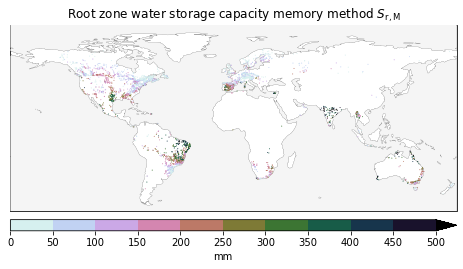

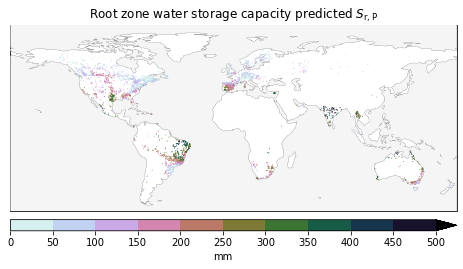

In [22]:
# sr memory method maps
cmap_sr1 = cm.get_cmap('cubehelix_r', 13)
cmap_sr1 = cmap_sr
bounds = np.linspace(0,500,11)
bounds2 = bounds
norm = mpl.colors.BoundaryNorm(bounds, cmap_sr1.N)

fig2 = plt.figure(figsize=(8,8))
# plt.subplots_adjust(wspace=0000.1,hspace=-0.4)
ax = fig2.add_subplot(111,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
s=ax.scatter(test_dfs.lon,test_dfs.lat,s=0.7,c=test_dfs['Sr_m'],edgecolors='face',marker='o',linewidths=0.1,cmap=cmap_sr1,norm=norm,zorder=102)
# cbar = plt.colorbar(s, orientation='vertical',spacing='proportional',extend='both', pad=0.02,aspect=15, norm=norm,shrink=0.35)
cbar = plt.colorbar(s, orientation='horizontal',spacing='proportional',extend='max', pad=0.02,aspect=40,norm=norm)
cbar.set_label(label='mm',size=10)
ax.set_title('Root zone water storage capacity memory method $S_\mathrm{r,M}$',size=12)
cbar.set_ticks(bounds)
fig2.savefig(f'{out_dir}/gridded_sr/figures/sr_m_points.jpg',bbox_inches='tight',dpi=300)

fig2 = plt.figure(figsize=(8,8))
# plt.subplots_adjust(wspace=0000.1,hspace=-0.4)
ax = fig2.add_subplot(111,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
s=ax.scatter(test_dfs.lon,test_dfs.lat,s=0.7,c=test_dfs['Sr_p'],edgecolors='face',marker='o',linewidths=0.1,cmap=cmap_sr1,norm=norm,zorder=102)
# cbar = plt.colorbar(s, orientation='vertical',spacing='proportional',extend='both', pad=0.02,aspect=15, norm=norm,shrink=0.35)
cbar = plt.colorbar(s, orientation='horizontal',spacing='proportional',extend='max', pad=0.02,aspect=40,norm=norm)
cbar.set_label(label='mm',size=10)
ax.set_title('Root zone water storage capacity predicted $S_\mathrm{r,P}$',size=12)
cbar.set_ticks(bounds)
# ax.set_title('(a)',size=9,loc='left')
fig2.savefig(f'{out_dir}/gridded_sr/figures/sr_predicted_points.jpg',bbox_inches='tight',dpi=300)



In [61]:
# mask output
data_xr_mean = data_xr_mean.where(pl[0,:,:]>=0)
data_xr_std = data_xr_std.where(pl[0,:,:]>=0)
data_xr_sm = data_xr_sm.where(pl[0,:,:]>=0)

data_xr_mean.to_netcdf(f'{work_dir}/output/gridded_sr/data_xr_mean.nc')

/tmp/ipykernel_1722/1412334434.py:27: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("Reds").copy()
  cmap_sr1.set_bad('lightgrey')


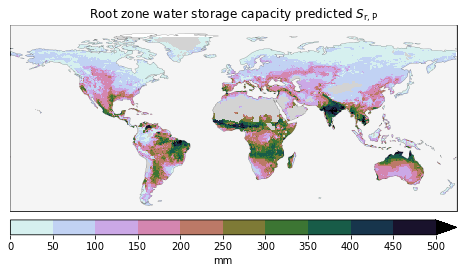

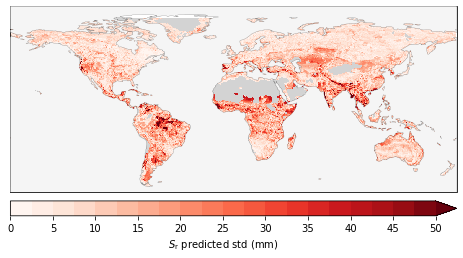

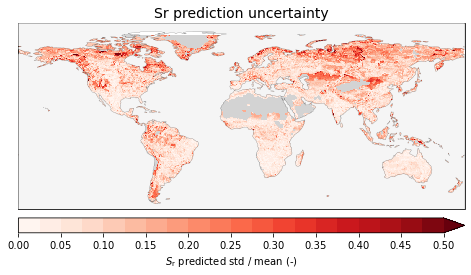

In [24]:
# sr predicted mean
bounds = np.linspace(0, 500,11)
bounds2 = np.linspace(0,500,11)
norm = mpl.colors.BoundaryNorm(bounds, cmap_sr.N)

fig2 = plt.figure(figsize=(8,8))
ax = fig2.add_subplot(111,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
a = data_xr_mean[:,:].plot(ax=ax, cmap=cmap_sr,levels=bounds, add_colorbar=False)
#ax.plot([lon[526],lon[526]],[-60,90],'k--',zorder=101)
cbar = plt.colorbar(a, orientation='horizontal',spacing='proportional',extend='max', pad=0.02,aspect=30,ticks=bounds2)
cbar.ax.tick_params(labelsize=10)
cbar.set_label(label='mm',size=10)
ax.set_title('Root zone water storage capacity predicted $S_\mathrm{r,P}$',size=12)
fig2.savefig(f'{out_dir}/gridded_sr/figures/sr_predicted_mean.jpg',bbox_inches='tight',dpi=300)

# standard deviation
from matplotlib import cm
cmap_sr1 = cm.get_cmap('Reds')
bounds = np.linspace(0,50,21)
bounds2 = np.linspace(0,50,11)
norm = mpl.colors.BoundaryNorm(bounds, cmap_sr1.N)
cmap_sr1.set_bad('lightgrey')

fig2 = plt.figure(figsize=(8,8))
ax = fig2.add_subplot(111,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
a = data_xr_std[:,:].plot(ax=ax, cmap=cmap_sr1,levels=bounds, add_colorbar=False)
#ax.plot([lon[526],lon[526]],[-60,90],'k--',zorder=101)
cbar = plt.colorbar(a, orientation='horizontal',spacing='proportional',extend='max', pad=0.02,aspect=30,ticks=bounds2)
cbar.ax.tick_params(labelsize=10)
cbar.set_label(label='$S_\mathrm{r}$ predicted std (mm)', size=10)
ax.set_title('',size=14)
fig2.savefig(f'{out_dir}/gridded_sr/figures/sr_predicted_std.jpg',bbox_inches='tight',dpi=300)

# relative standard deviation
bounds = np.linspace(0,0.5,21)
bounds2 = np.linspace(0,0.5,11)
norm = mpl.colors.BoundaryNorm(bounds, cmap_sr1.N)

fig2 = plt.figure(figsize=(8,8))
ax = fig2.add_subplot(111,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
a = data_xr_sm[:,:].plot(ax=ax, cmap=cmap_sr1,levels=bounds, add_colorbar=False)
#ax.plot([lon[526],lon[526]],[-60,90],'k--',zorder=101)
cbar = plt.colorbar(a, orientation='horizontal',spacing='proportional',extend='max', pad=0.02,aspect=30,ticks=bounds2)
cbar.ax.tick_params(labelsize=10)
cbar.set_label(label='$S_\mathrm{r}$ predicted std / mean (-)', size=10)
ax.set_title('Sr prediction uncertainty',size=14)
fig2.savefig(f'{out_dir}/gridded_sr/figures/sr_predicted_std_mean.jpg',bbox_inches='tight',dpi=300)


## REFERENCE ROOT PRODUCTS

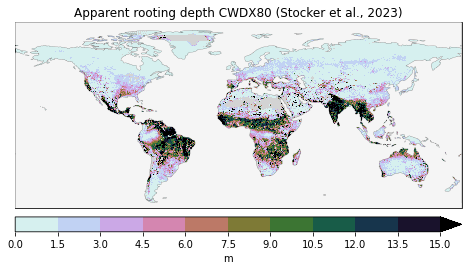

In [25]:
# stocker root depth
bounds = np.linspace(0,15,11)
bounds2 = np.linspace(0,15,11)
norm = mpl.colors.BoundaryNorm(bounds, cmap_sr.N)

sd = xr.open_dataset(f'{work_dir}/data/reference_sr/stocker/zroot_cwd80.nc')
sd = sd.zroot_cwd80/1000 #convert to meters

lvls = np.linspace(0,15,12) # scale W-E paper
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
a = sd.plot(ax=ax, cmap=cmap_sr, add_colorbar=False, vmin=0, vmax=10, levels=bounds)
cbar = plt.colorbar(a, orientation='horizontal',spacing='proportional',extend='max', pad=0.02,aspect=30,ticks=bounds2)
cbar.ax.tick_params(labelsize=10)
cbar.set_label(label='m',size=10)
ax.set_title(f'Apparent rooting depth CWDX80 (Stocker et al., 2023)',size=12)
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
fig.savefig(f'{work_dir}/output/gridded_sr/figures/sr_stocker_zroot_cwd80.jpg',bbox_inches='tight',dpi=300)

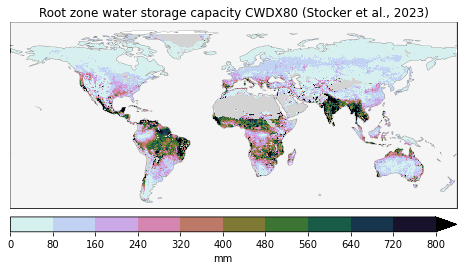

In [26]:
# stocker T80 sr
bounds = np.linspace(0,800,11)
bounds2 = np.linspace(0,800,11)
norm = mpl.colors.BoundaryNorm(bounds, cmap_sr.N)

s = xr.open_dataset(f'{work_dir}/data/reference_sr/stocker/cwdx80_cru_grid.nc')
s = s.cwdx80
s = s.where(pl[0,:,:]>=0)

fig2 = plt.figure(figsize=(8,8))
ax = fig2.add_subplot(111,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
a = s.plot(ax=ax, cmap=cmap_sr,levels=bounds, add_colorbar=False)
cbar = plt.colorbar(a, orientation='horizontal',spacing='proportional',extend='max', pad=0.02,aspect=30,ticks=bounds2)
cbar.ax.tick_params(labelsize=10)
cbar.set_label(label='mm',size=10)
ax.set_title(f'Root zone water storage capacity CWDX80 (Stocker et al., 2023)',size=12)
fig2.savefig(f'{work_dir}/output/gridded_sr/figures/sr_stocker_t80.jpg',bbox_inches='tight',dpi=300)

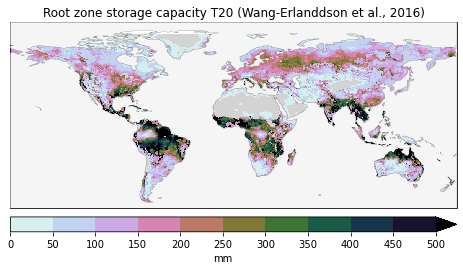

In [27]:
# lan cru sr T20
bounds = np.linspace(0,500,11)
bounds2 = np.linspace(0,500,11)
norm = mpl.colors.BoundaryNorm(bounds, cmap_sr.N)

# cru T20 Lan
l = xr.open_dataset(f'{work_dir}/data/reference_sr/lan/sr_cru_20yrs.nc')
l = l.sr_cru_20yrs[0]
l = l.where(pl[0,:,:]>=0)

fig2 = plt.figure(figsize=(8,8))
ax = fig2.add_subplot(111,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
a = l.plot(ax=ax, cmap=cmap_sr,levels=bounds, add_colorbar=False)
cbar = plt.colorbar(a, orientation='horizontal',spacing='proportional',extend='max', pad=0.02,aspect=30,ticks=bounds2)
cbar.ax.tick_params(labelsize=10)
cbar.set_label(label='mm', size=10)
ax.set_title('Root zone storage capacity T20 (Wang-Erlanddson et al., 2016)',size=12)
fig2.savefig(f'{work_dir}/output/gridded_sr/figures/sr_lan_t20.jpg',bbox_inches='tight',dpi=300)

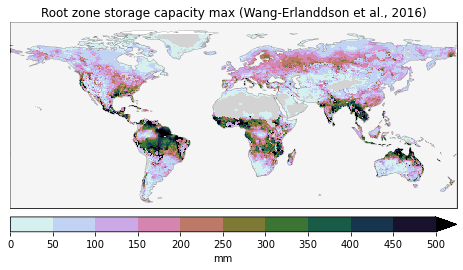

In [28]:
# lan cru sr max
bounds = np.linspace(0, 500,11)
bounds2 = np.linspace(0,500,11)
norm = mpl.colors.BoundaryNorm(bounds, cmap_sr.N)

l = xr.open_dataset(f'{work_dir}/data/reference_sr/lan/sr_cru_max.nc')
l = l.sr_cru_max[0]
l = l.where(pl[0,:,:]>=0)

fig2 = plt.figure(figsize=(8,8))
ax = fig2.add_subplot(111,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
a = l.plot(ax=ax, cmap=cmap_sr,levels=bounds, add_colorbar=False)
cbar = plt.colorbar(a, orientation='horizontal',spacing='proportional',extend='max', pad=0.02,aspect=30,ticks=bounds2)
cbar.ax.tick_params(labelsize=10)
cbar.set_label(label='mm', size=10)
ax.set_title('Root zone storage capacity max (Wang-Erlanddson et al., 2016)',size=12)
fig2.savefig(f'{work_dir}/output/gridded_sr/figures/sr_lan_max.jpg',bbox_inches='tight',dpi=300)

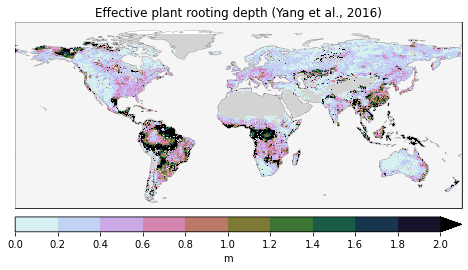

In [29]:
# Yang effective rooting depth
bounds = np.linspace(0,2,11)
bounds2 = np.linspace(0,2,11)
norm = mpl.colors.BoundaryNorm(bounds, cmap_sr.N)

y = xr.open_dataset(f'{work_dir}/data/reference_sr/yang/data/Effective_Rooting_Depth.nc')
y = y.Band1
y = y.where(pl[0,:,:]>=0)

fig2 = plt.figure(figsize=(8,8))
ax = fig2.add_subplot(111,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
a = y.plot(ax=ax, cmap=cmap_sr,levels=bounds, add_colorbar=False)
cbar = plt.colorbar(a, orientation='horizontal',spacing='proportional',extend='max', pad=0.02,aspect=30,ticks=bounds2)
cbar.ax.tick_params(labelsize=10)
cbar.set_label(label='m', size=10)
ax.set_title('Effective plant rooting depth (Yang et al., 2016)',size=12)
fig2.savefig(f'{work_dir}/output/gridded_sr/figures/yang_effective_rooting_depth.jpg',bbox_inches='tight',dpi=300)


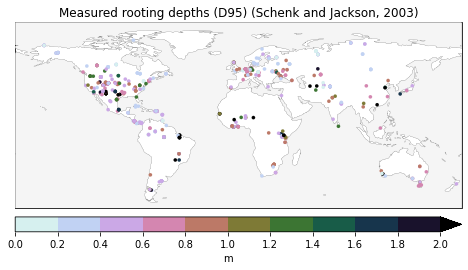

In [30]:
#Schenk and Jackson observed rooting depths
s = pd.read_csv(f'{work_dir}/data/reference_sr/Schenk+Jackson2003-rootzone-point-data.csv',index_col=0,delimiter=';')

# what are extrapolated columns?

fig2 = plt.figure(figsize=(8,8))
ax = fig2.add_subplot(111,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
s = ax.scatter(s.Longitude,s.Latitude,s=12,c=s.D95,edgecolors='face',marker='o',linewidths=0.1,cmap=cmap_sr,norm=norm,zorder=102)
cbar = plt.colorbar(s, orientation='horizontal',spacing='proportional',extend='max', pad=0.02,aspect=30,ticks=bounds2)
cbar.ax.tick_params(labelsize=10)
cbar.set_label(label='m', size=10)
ax.set_title('Measured rooting depths (D95) (Schenk and Jackson, 2003)',size=12)
fig2.savefig(f'{work_dir}/output/gridded_sr/figures/schenkjackson_rooting_depth_d95.jpg',bbox_inches='tight',dpi=300)

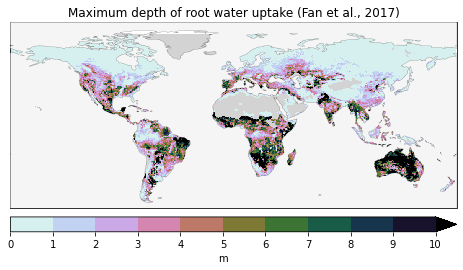

In [31]:
# Fan maximum depth of root water uptake
bounds = np.linspace(0,10,11)
bounds2 = np.linspace(0,10,11)
norm = mpl.colors.BoundaryNorm(bounds, cmap_sr.N)

f = xr.open_dataset(f'{work_dir}/data/reference_sr/fan/maxroot_allregions_crugrid2.nc') #conservative remapping done
f = f.root_depth
f = f.where(pl[0,:,:]>=0)

fig2 = plt.figure(figsize=(8,8))
ax = fig2.add_subplot(111,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
a = f.plot(ax=ax, cmap=cmap_sr,levels=bounds, add_colorbar=False)
# a = f2.plot(ax=ax, cmap=cmap_sr,levels=bounds, add_colorbar=False,zorder=101)
# a = f3.plot(ax=ax, cmap=cmap_sr,levels=bounds, add_colorbar=False,zorder=101)
# a = f4.plot(ax=ax, cmap=cmap_sr,levels=bounds, add_colorbar=False,zorder=101)
# a = f5.plot(ax=ax, cmap=cmap_sr,levels=bounds, add_colorbar=False,zorder=101)
cbar = plt.colorbar(a, orientation='horizontal',spacing='proportional',extend='max', pad=0.02,aspect=30,ticks=bounds2)
cbar.ax.tick_params(labelsize=10)
cbar.set_label(label='m', size=10)
ax.set_title('Maximum depth of root water uptake (Fan et al., 2017)',size=12)
fig2.savefig(f'{work_dir}/output/gridded_sr/figures/fan_max_depth_rootwateruptake.jpg',bbox_inches='tight',dpi=300)



## CORRELATIONS

In [56]:
p = data_xr_mean

f = xr.open_dataset(f'{work_dir}/data/reference_sr/fan/maxroot_allregions_crugrid2.nc') #conservative remapping done
f = f.root_depth
f = f.where(pl[0,:,:]>=0)

ya = xr.open_dataset(f'{work_dir}/data/reference_sr/yang/data/Effective_Rooting_Depth.nc')
ya = ya.Band1
ya = ya.where(pl[0,:,:]>=0)

# cru T20 Lan
l = xr.open_dataset(f'{work_dir}/data/reference_sr/lan/sr_cru_20yrs.nc')
l = l.sr_cru_20yrs[0]
l = l.where(pl[0,:,:]>=0)

s = xr.open_dataset(f'{work_dir}/data/reference_sr/stocker/cwdx80_cru_grid.nc')
s = s.cwdx80
s = s.where(pl[0,:,:]>=0)

272
52147
272
50537
272
49564
272
10973


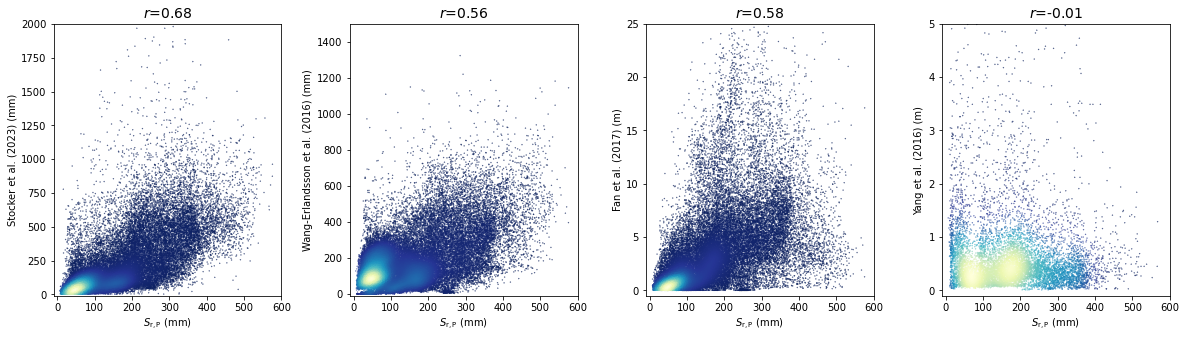

In [72]:
fig = plt.figure(figsize=(20,5))
plt.subplots_adjust(wspace=0.3)
ax = fig.add_subplot(141)
p = xr.open_dataset(f'{work_dir}/output/gridded_sr/data_xr_mean.nc')
x=p.sr_p
print(len(x))
y = s
x = x.stack(flat=['lat','lon']).values
y = y.stack(flat=['lat','lon']).values
nan_indices = np.logical_or(np.isnan(x), np.isnan(y))
x[nan_indices] = np.nan
y[nan_indices] = np.nan
x = x[~np.isnan(x)]
y = y[~np.isnan(y)]
kde = gaussian_kde(np.vstack([x, y]))
z = kde(np.vstack([x, y]))
ax.scatter(x,y,c=z,s=0.1,marker='o',cmap='YlGnBu_r')
ax.set_xlim(-10,600)
ax.set_ylim(-10,2000)
ax.set_title(f'$r$={np.round(np.corrcoef(x,y)[0,1],2)}',size=14)
ax.set_xlabel('$S_\mathrm{r,P}$ (mm)')
ax.set_ylabel('Stocker et al. (2023) (mm)')
print(len(x))

ax = fig.add_subplot(142)
p = xr.open_dataset(f'{work_dir}/output/gridded_sr/data_xr_mean.nc')
x=p.sr_p
print(len(x))
y = l
x = x.stack(flat=['lat','lon']).values
y = y.stack(flat=['lat','lon']).values
nan_indices = np.logical_or(np.isnan(x), np.isnan(y))
x[nan_indices] = np.nan
y[nan_indices] = np.nan
x = x[~np.isnan(x)]
y = y[~np.isnan(y)]
kde = gaussian_kde(np.vstack([x, y]))
z = kde(np.vstack([x, y]))
ax.scatter(x,y,c=z,s=0.1,marker='o',cmap='YlGnBu_r')
ax.set_xlim(-10,600)
ax.set_ylim(-10,1500)
ax.set_title(f'$r$={np.round(np.corrcoef(x,y)[0,1],2)}',size=14)
ax.set_xlabel('$S_\mathrm{r,P}$ (mm)')
ax.set_ylabel('Wang-Erlandsson et al. (2016) (mm)')
print(len(x))

ax = fig.add_subplot(143)
p = xr.open_dataset(f'{work_dir}/output/gridded_sr/data_xr_mean.nc')
x=p.sr_p
print(len(x))
y = f
x = x.stack(flat=['lat','lon']).values
y = y.stack(flat=['lat','lon']).values
nan_indices = np.logical_or(np.isnan(x), np.isnan(y))
x[nan_indices] = np.nan
y[nan_indices] = np.nan
x = x[~np.isnan(x)]
y = y[~np.isnan(y)]
kde = gaussian_kde(np.vstack([x, y]))
z = kde(np.vstack([x, y]))
ax.scatter(x,y,c=z,s=0.1,marker='o',cmap='YlGnBu_r')
ax.set_xlim(-10,600)
ax.set_ylim(-0.5,25)
ax.set_title(f'$r$={np.round(np.corrcoef(x,y)[0,1],2)}',size=14)
ax.set_xlabel('$S_\mathrm{r,P}$ (mm)')
ax.set_ylabel('Fan et al. (2017) (m)')
print(len(x))

ax = fig.add_subplot(144)
p = xr.open_dataset(f'{work_dir}/output/gridded_sr/data_xr_mean.nc')
x=p.sr_p
print(len(x))
y = ya
x = x.stack(flat=['lat','lon']).values
y = y.stack(flat=['lat','lon']).values
nan_indices = np.logical_or(np.isnan(x), np.isnan(y))
x[nan_indices] = np.nan
y[nan_indices] = np.nan
x = x[~np.isnan(x)]
y = y[~np.isnan(y)]
kde = gaussian_kde(np.vstack([x, y]))
z = kde(np.vstack([x, y]))
ax.scatter(x,y,c=z,s=0.1,marker='o',cmap='YlGnBu_r')
ax.set_xlim(-10,600)
ax.set_ylim(-0.1,5)
ax.set_title(f'$r$={np.round(np.corrcoef(x,y)[0,1],2)}',size=14)
ax.set_xlabel('$S_\mathrm{r,P}$ (mm)')
ax.set_ylabel('Yang et al. (2016) (m)')
print(len(x))
fig.savefig(f'{work_dir}/output/gridded_sr/figures/scatters.jpg',bbox_inches='tight',dpi=600)